This notebook, implements and visualizes the ldaseq model on the UNDP jobs dataset. ldaseq is a dynamic lda model that shows the development of topics over time. 

In [ ]:
import pickle, gensim
import pandas as pd
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
import numpy as np
!pip install pyLDAvis
import pyLDAvis
from gensim.matutils import hellinger
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Load jobs dataframe

In [ ]:
df = 'drive/My Drive/UNDP/data/jobs_2000.pkl'
with open(df, 'rb') as f:
    df = pickle.load(f)

Prepepare to train the model

In [ ]:
index = pd.Index(df['year'])
index.value_counts() #time_stices should be changed based on counts.

time_slice = [605, 17, 1311]
years = [18,19,20]
num_topics = 5
docs = [item.split() for item in df['background']]
dictionary = gensim.corpora.Dictionary(docs)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs ]

Train the dynamic topic model and save it to disk (Skip this part if you already have the model)

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=doc_term_matrix, id2word=dictionary, time_slice=time_slice, num_topics=num_topics)
with open('drive/My Drive/UNDP/data/ldaseq2.pkl', 'wb') as f:
     pickle.dump(ldaseq, f)

If you have the model you can start from this cell: Load the trained ldaseq model from disk

In [ ]:
model = 'drive/My Drive/UNDP/data/ldaseq.pkl'
with open(model, 'rb') as f:
    model = pickle.load(f)

doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=0, corpus=doc_term_matrix)

Probabilistic visualization of the topics

In [ ]:
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

Graphical visualization of the topics

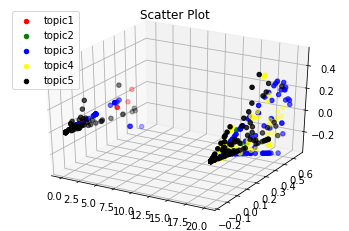

In [ ]:
doc_topic = doc_topic.tolist()
#Create topical bins
topics = []
for i in range(num_topics):
    topics.append([])

#Add year info to docs_topic matrix and separate docs into topical bins
for i in range(len(doc_topic)):
    doc = doc_topic[i]
    for j in time_slice:
        if i <= j: 
           doc_topic[i].append(years[time_slice.index(j)]) #year info addition
           topics[doc.index(max(doc[:-1]))].append(doc) #topical bins separation
           break

#Dimensionality reduction
topics = np.array(topics)
pca = PCA(n_components=2) 
Dtopics = []
zs = []
for topic in topics:
    topic = np.array(topic)
    probValues = topic[:,0:len(topic[0])-1]
    Dtopics.append(pca.fit_transform(probValues))
    zs.append(topic[:,-1])

#Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("Scatter Plot")
colors = ['red','green','blue','yellow', 'black']
labels = ['topic1','topic2','topic3','topic4','topic5']
i=0
for topic in Dtopics:
    x = topic[:,0].tolist()
    y = topic[:,1].tolist()
    z = zs[i] 
    ax.scatter(z, x, y, color=colors[i], label=labels[i])
    i+=1
plt.legend()
plt.show()